# Roll decay test parameter identification
Various ways to derive roll damping by parameter identification from roll decay tests are investigated.

Three different ways to conduct parameter identification are investigated:
* **report** : Damping is first extracted from time signal by measuring the peaks of the oscillation, using "Norwegian method". This solution is taken straight from an existing SSPA report, so the calculation is not done in this notebook.
* **sim** : Roll decay simulation is run in the optimization loop
* **direct** : Velocity and acceleration from the model test is derived numerically so that the roll diff equation can be solved directly without simulation.

## Conclusions
### report 
Gives good results but is not a very general solution since it has a very strong dependency of the exact diff equation formulation.

### sim
Gives poor results since the optimization is struggling to find a good solution, but this can definatelly be improved very easily. Another bad thing is that an initial guess of parameters is needed for the solution to converge. 

### direct
Gives good results and seem to be the fastest and most robust solution. This method does however need some filtering to remove measurement noice. Perhaps this can be improved by applying Kalman filter or using Maximum Likelihood regression assumming that the measurement noice has a normal distribution

## Further work
None of the methods worked well unless the initial large roll angles were removed, probably beacause the nonlinearities are higher than quadratic for this case. Removing these angles (making the model valid for only smaller angles) is one option. Another option is to allow higher order damping terms in the simulation model for the fitting (the higher order terms can later be transfered to a model with linear och quadratic order at a later stage if required). How the cutting affects the parameter identification should be further investigated.

A sensitivity stuffy regarding the impact of lowpass filtering on the parameter identification should also be conducted. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
from rolldecay.filtering import lowpass_filter
import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect

## Roll decay model test

In [3]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)
scale = 29.565
df.index*=np.sqrt(scale)  # To full scale

In [4]:
fig,ax = plt.subplots()
fig.set_size_inches(4,0.5)
df.plot(y='phi',ax=ax);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(False)
ax.legend().set_visible(False)
fname = os.path.join(rolldecay.paper_figures_path,'rolldecay.pdf')
fig.tight_layout()
fig.savefig(fname=fname,dpi=300)

### Cutting the file at max value 

In [20]:
index = df['phi'].abs().idxmax()
df_cut = df.loc[index:].copy()

In [21]:
df_cut['phi_raw'] = df_cut['phi']

### Low pass filtration of signal to remove measurement noice

In [22]:
ts = np.mean(np.diff(df_cut.index))
fs = 1/ts
df_cut['phi'] = lowpass_filter(data=df_cut['phi_raw'], cutoff=0.1, fs=fs, order=5)

### Also cut the end of the signal

In [23]:
df_cut = df_cut.iloc[300:-300]

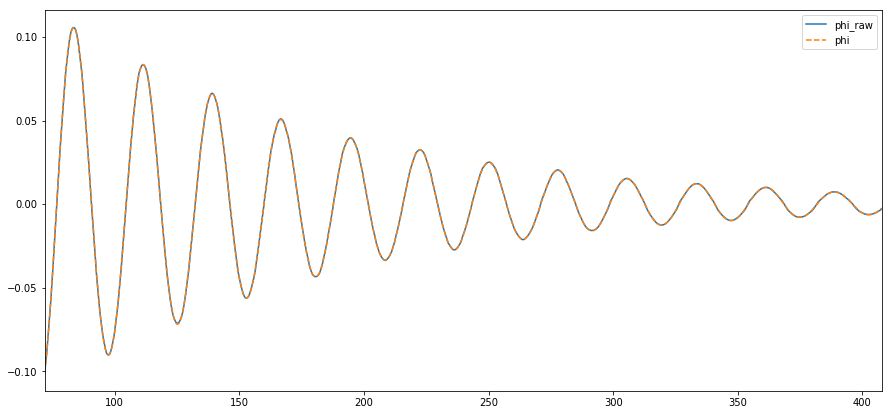

In [24]:
fig,ax=plt.subplots()
df_cut.plot(y='phi_raw', ax=ax)
df_cut.plot(y='phi', ax=ax, style='--')
ax.legend();

In [25]:
df_cut['phi1d'] = np.gradient(df_cut['phi'].values,df_cut.index.values)
df_cut['phi2d'] = np.gradient(df_cut['phi1d'].values,df_cut.index.values)

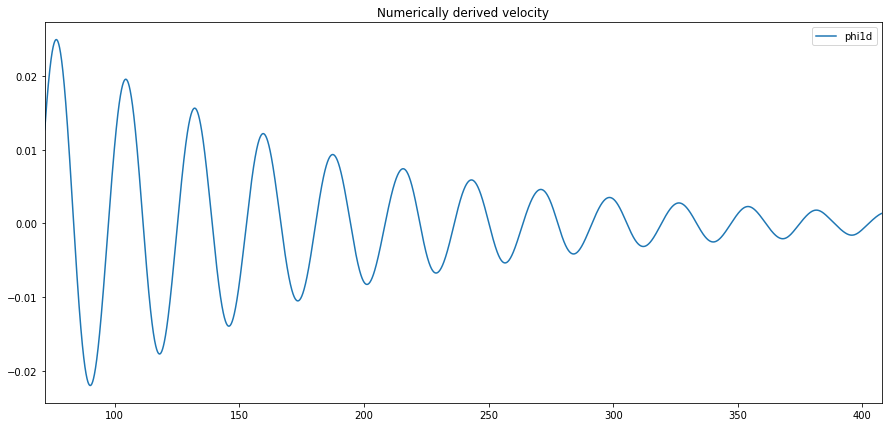

In [26]:
fig,ax=plt.subplots()
df_cut.plot(y='phi1d', ax=ax)
ax.set_title('Numerically derived velocity');

Text(0.5, 1.0, 'Numerically derived acceleration')

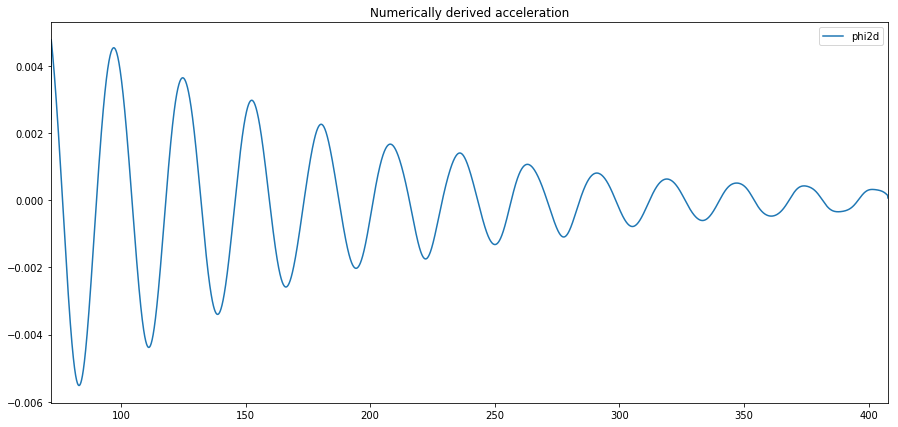

In [27]:
fig,ax=plt.subplots()
df_cut.plot(y='phi2d', ax=ax)
ax.set_title('Numerically derived acceleration')

    

In [28]:
parameters_direct,pcov = parameter_identification.fit_direct(df=df_cut)
parameters_direct

{'d': -0.1656947129495172,
 'omega0': 0.22628460551567614,
 'zeta': 0.04306528264125665}

In [29]:
phi0 = df_cut['phi'].iloc[0]
phi1d0 = df_cut['phi1d'].iloc[0]
df_sim_direct = simulate(t=df_cut.index, **parameters_direct, phi0=phi0, phi1d0=phi1d0)

In [30]:
T0_guess = 27
omega0_guess = 2*np.pi/T0_guess
d_guess = 0.16  # Qudratic damping
zeta_guess = 0.03  # Linear damping
p0=[omega0_guess,d_guess,zeta_guess]
#p0=None

parameters = parameter_identification.fit(df=df_cut, p0=p0)

In [31]:
parameters

{'d': 0.16052435351685646,
 'omega0': 0.22881813526586803,
 'zeta': 0.030204351754539758}

In [32]:
2*np.pi/parameters['omega0']

27.459297751373757

In [33]:
df_sim = simulate(t=df_cut.index, **parameters, phi0=phi0, phi1d0=phi1d0)

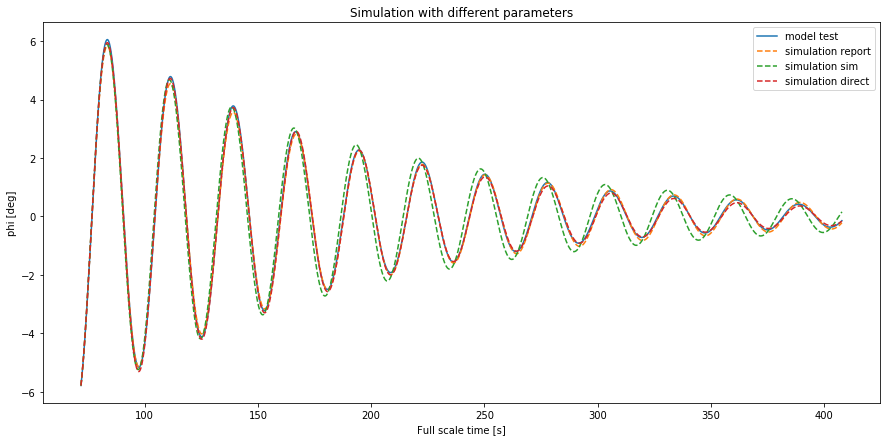

In [34]:
parameters_report = {
    'd': 0.165,
    'omega0': 2*np.pi/27.77,
    'zeta': 0.0336,
}


df_sim_report = simulate(t=df_cut.index, **parameters_report, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()

from collections import OrderedDict
dfs = OrderedDict()
dfs['model test']={'df':df_cut,'style':'-', 'alpha':1}
dfs['simulation report']={'df':df_sim_report}
dfs['simulation sim']={'df':df_sim}
dfs['simulation direct']={'df':df_sim_direct}

for label,data in dfs.items():
    df_ = data['df']
    style = data.get('style','--')
    alpha = data.get('alpha',1)
    ax.plot(df_.index,np.rad2deg(df_['phi']),style, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('phi [deg]')
ax.set_title('Simulation with different parameters');

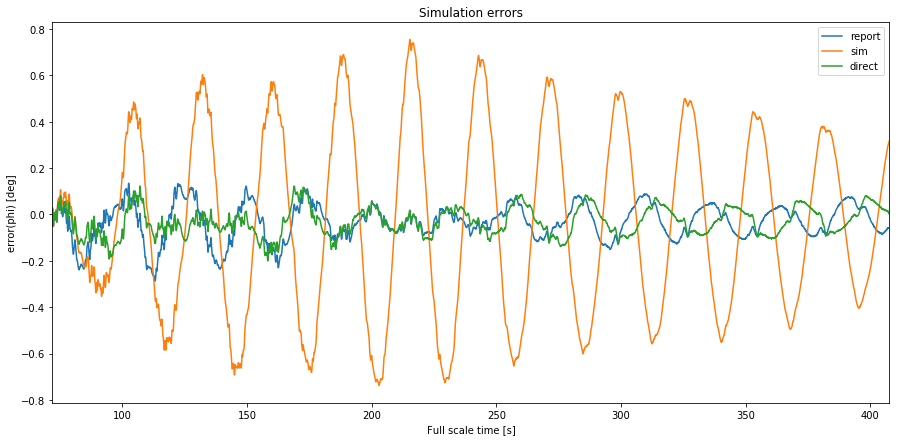

In [35]:
fig,ax = plt.subplots()
df_errors = pd.DataFrame(index=df_cut.index)
df_errors['report'] = df_sim_report['phi'] - df_cut['phi_raw']
df_errors['sim'] = df_sim['phi'] - df_cut['phi_raw']
df_errors['direct'] = df_sim_direct['phi'] - df_cut['phi_raw']

df_errors_deg = np.rad2deg(df_errors)

df_errors_deg.plot(ax=ax)
ax.set_title('Simulation errors')
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('error(phi) [deg]');


In [36]:
def RMS_error(error_phi,phi_max):
    return (np.sqrt((error_phi/phi_max)**2)).mean()

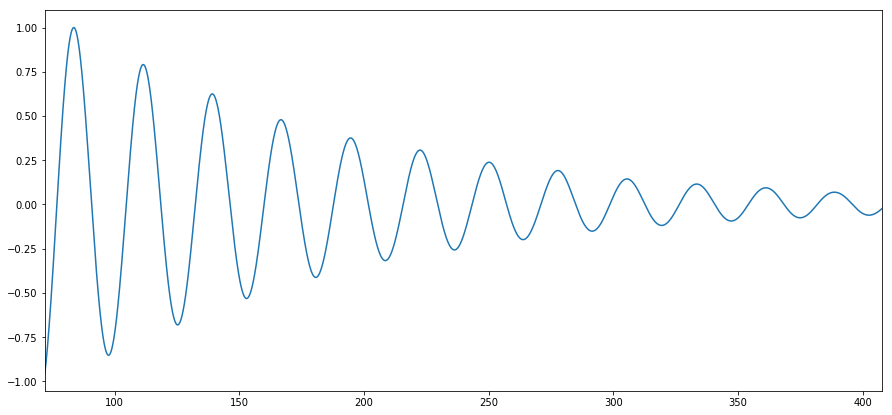

In [37]:
phi_max = df_cut['phi'].abs().max()
(df_cut['phi']/phi_max).plot()

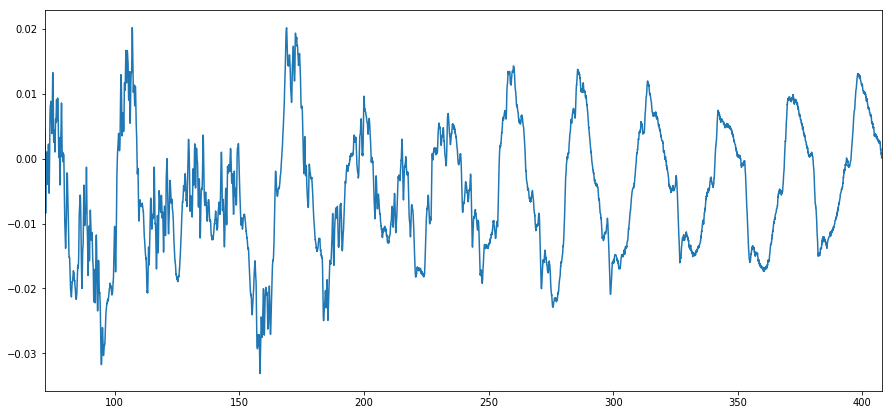

In [38]:
(df_errors['direct']/phi_max).plot()

Text(0.5, 1.0, "RMS error(phi'/max(phi))")

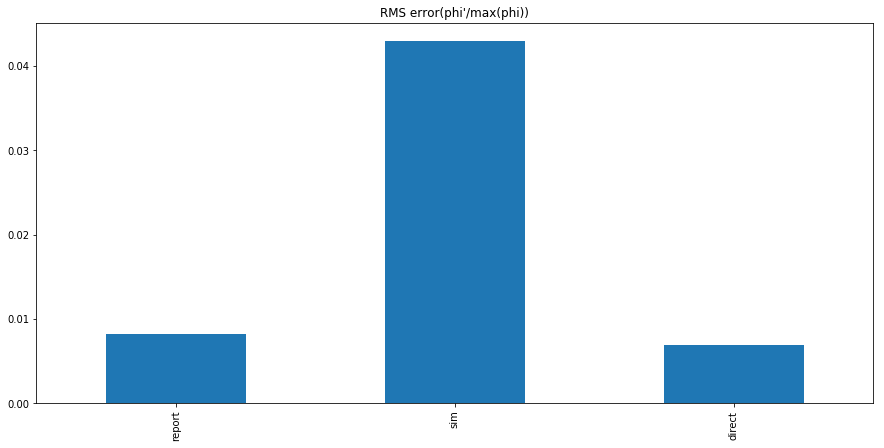

In [39]:
fig,ax = plt.subplots()
phi_max = df['phi'].abs().max()
s_RMS = df_errors.apply(func=RMS_error,phi_max=phi_max,axis=0)
s_RMS.plot(kind='bar');
ax.set_title("RMS error(phi'/max(phi))")

In [40]:

#def fit_optimize(df, p0=None):
#    
#    def error(x):
#    
#        omega0, d, zeta = x[0], x[1], x[2]
#    
#        phi_sim = f(df=df, omega0=omega0, d=d, zeta=zeta)
#        
#        phi = df['phi']
#        phi_max = phi.abs().max()
#        return (((phi_sim-phi)/phi_max)**2).mean()
#    
#    
#    if p0 is None:
#        p0 = [1,1,1]
#        
#    #return minimize(fun=error, x0=p0)
#    return basinhopping(func=error, x0=p0)
#    

In [41]:
#T0_guess = 27
#omega0_guess = 2*np.pi/T0_guess
#d_guess = 0.16  # Qudratic damping
#zeta_guess = 0.03  # Linear damping
#
#
#parameters = fit_optimize(df=df_cut, p0=[omega0_guess,d_guess,zeta_guess])

#parameters_optimize = {
#    'omega0':parameters.x[0],
#    'd':parameters.x[1],
#    'zeta':parameters.x[2],
#    
#}
#parameters_optimize

In [42]:
#df_sim2 = simulate(t=df_cut.index, **parameters_optimize, phi0=phi0, phi1d0=phi1d0)
#
#fig,ax = plt.subplots()
#df_cut.plot(y='phi', ax=ax, label='model test')
#df_sim2.plot(y='phi', ax=ax, label='simulation2')
#ax.set_title('Simulation with parameters from report')